# Phase-resolved turbulent dissipation

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
from scipy import optimize
from scipy.signal import detrend
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as tck
from roxsi_pyfuns.plotting import multiple_formatter
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import stats as rps
from roxsi_pyfuns import turbulence as rpt

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')
figdir = os.path.join(vec_root, 'img')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))


## 20-min test case
Use C3 Vector as test case.

Iterating over bursts ...


  0%|          | 0/25 [00:00<?, ?it/s]

Concatenating dataframes ...


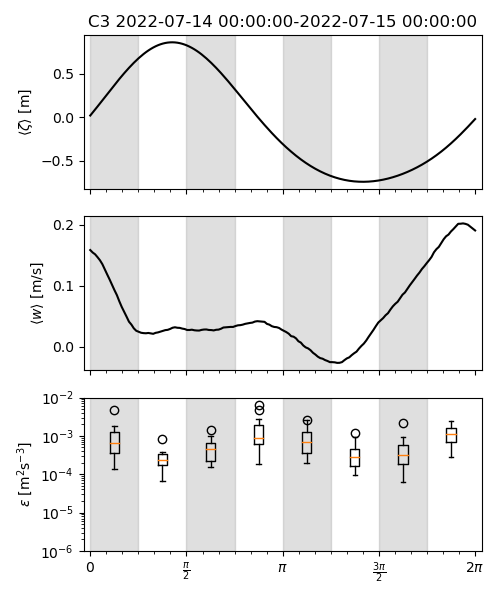

In [4]:
# Serial numbers and corresponding mooring IDs
ser = '17219'
mid = 'C3'
# ser = '17371'
# mid = 'C4'
# ser = '17212'
# mid = 'C2'
fs = 16 # Sampling freq
# Sample period
# t0 = pd.Timestamp('2022-07-17 11:00:00')
# t0 = pd.Timestamp('2022-07-13 00:00:00')
t0 = pd.Timestamp('2022-07-14 00:00:00')
t1 = t0 + pd.Timedelta(hours=24)
# Define expected headings in PCA coordinates for C2 & C3
heading_exp = {'C2': -125, 'C3': -90, 'C4': None}

# Read netcdf file
ncdir = os.path.join(vec_root, mid)
fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
    str(t0.strftime('%Y%m%d'))))
dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

# Define number of sub-segments per wave cycle (should be even)
ncyc = 8
# Minimum R^2 threshold for inertial subrange fits
r2_thresh = 0.9

# Lists for hourly burst averages
wave_int_e = [] # Interpolated wave elevations
wave_int_u = [] # Interpolated wave u velocities
wave_int_v = [] # Interpolated wave v velocities
wave_int_w = [] # Interpolated wave w velocities
# Dissipation rates per wave-cycle subsegment
diss_subseg = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
# Mean horizontal velocities U per wave-cycle subsegment
U_subseg = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}

# Wave couter
wcnt = 0

# Iterate over bursts
time_range = pd.date_range(t0, t1, freq='1H')
print('Iterating over bursts ...')
for t0b in tqdm(time_range):
    t1b = t0b + pd.Timedelta(hours=1)
    if t1b > t1:
        continue
    # print('{}-{}'.format(t0b, t1b.time()))
    # Select sample period
    seg = dsv.sel(time=slice(t0b, t1b))
    eta = seg.eta_lin_krms.copy().to_series() # Surface elevation

    # Convert velocities to cross-/alongshore
    # x vel, despiked
    uxd = seg.uxd.to_dataframe() # Convert to pandas
    uxd = uxd.interpolate(method='bfill').interpolate('ffill')
    uxd -= uxd.mean()
    # y vel, despiked
    uyd = seg.uyd.to_dataframe() # Convert to pandas
    uyd = uyd.interpolate(method='bfill').interpolate('ffill')
    uyd -= uyd.mean()
    # z vel, despiked
    uzd = seg.uzd.to_dataframe() # Convert to pandas
    uzd = uzd.interpolate(method='bfill').interpolate('ffill')
    uzd -= uzd.mean()
    # Rotate velocities to cross/alongshore & vertical using PCA
    ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                       uy=uyd.values.squeeze(), 
                                       uz=uzd.values.squeeze(),
                                       heading_exp=heading_exp[mid], 
                                       # print_msg=True,
                                       )

    # Estimate full w-spectrum (testing)
    wspec = rpws.spec_uvz(uw, fs=16)

    # Get zero-crossings, min. 4-sec waves
    zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=4*16)
    nwaves = len(Hw)
    # Compute H(1/3)
    Hws = np.sort(Hw) # Sorted wave heights
    H13 = np.mean(Hws[2*(nwaves//3):]) # Mean of highest 1/3 of waves
    # Define phase (x) axis to interpolate to
    n_phase = 160 # Number of points in phase axis
    min_period = 5 # Min. wave period (sec) to include

    # Lists for storing dataframes of spectral segments for merging
    dfs_lists = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
    # Also store subsegment-mean velocities U
    Us = {'q{}'.format(n): [] for n in range(1,ncyc+1)}
    # Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
    for zi,zc0 in enumerate(zc[:-1]):
        # Only include waves with T > min_period sec
        Tw = (eta.index[zc[zi+1]] - eta.index[zc[zi]]).total_seconds()
        if Tw < min_period:
            continue
        # Also only include high waves
        Hwi = Hw[zi]
        if Hwi < H13:
            continue
        # Wave surface elevation, u, v and w for current wave
        eta_wave = eta.iloc[zc0:zc[zi+1]]
        u_wave = ucs[zc0:zc[zi+1]]
        v_wave = uls[zc0:zc[zi+1]]
        w_wave = uw[zc0:zc[zi+1]]
        # Surface elevation
        df_e = rpzc.interpolate_phase(eta_wave.squeeze(), N=n_phase, 
                                      label='eta_int_{:04d}'.format(wcnt))
        wave_int_e.append(df_e)
        # Cross-shore vel.
        df_u = rpzc.interpolate_phase(u_wave.squeeze(), N=n_phase, 
                                      label='u_int_{:04d}'.format(wcnt))
        wave_int_u.append(df_u)
        # Long-shore vel.
        df_v = rpzc.interpolate_phase(v_wave.squeeze(), N=n_phase, 
                                      label='u_int_{:04d}'.format(wcnt))
        wave_int_v.append(df_v)
        # Vertical vel.
        df_w = rpzc.interpolate_phase(w_wave.squeeze(), N=n_phase, 
                                      label='u_int_{:04d}'.format(wcnt))
        wave_int_w.append(df_w)
        # Increase wave counter
        wcnt =+ 1

        # Estimate spectra for 1/ncyc wave cycles
        nsub = n_phase // ncyc
        # Frequencies
        n_freqs = int(np.floor(nsub / 2 )) # No. of frequency bands
        # Wavenumbers to interpolate spectrum to
        n_int = n_freqs * 3 # Number of wavenumbers to interpolate to
        kmin = (2*np.pi) / 0.5 # Min. interpolation wavenumber
        kmax = (2*np.pi) / 0.05 # Max. interpolation wavenumber
        # ki = 2 * np.pi / np.linspace(0.5, 0.05, int(n_freqs)) # Interp. k
        ki = np.linspace(kmin, kmax, n_int)
        # Initialize dict to store spectral dataframes
        dfs = {}
        for i in range(ncyc):
            # Get short-segment velocities
            useg = df_u.iloc[i*nsub:(i+1)*nsub].values.squeeze()
            vseg = df_v.iloc[i*nsub:(i+1)*nsub].values.squeeze()
            wseg = df_w.iloc[i*nsub:(i+1)*nsub].values.squeeze()
            # Compute mean current and check that U >> dU for segment
            U = np.sqrt(np.mean(useg)**2 + np.mean(vseg)**2).item() # Mean orb. vel. mag.
            umag = np.sqrt(useg**2 + vseg**2) # Orb. vel. magnitude, not mean
            dU = np.std(umag) # Variability in umag (following George et al., 1994)
            # Check U/dU ratio
            if (U / dU) < 1:
                # U vs. dU ratio (Eq (6) of George et al., 1994) too small
                # Use U / dU = 1 as threshold following Rosman & Gerbi (2017), Fig. 9
                continue
            # Estimate k-spectrum from wseg following George et al. (1994)
            dfs['q{}'.format(i+1)] = rpt.k_spec_wavephase(w=wseg, U=U, k_int=ki)
            # Save U
            Us['q{}'.format(i+1)].append(U)

        # Save dataframes to list for merging
        for n in range(1, ncyc+1):
            if 'q{}'.format(n) in dfs.keys():
                dfs_lists['dfs{}'.format(n)].append(dfs['q{}'.format(n)])

    # Concatenate spectral dataframes
    dfs = {}
    for n in range(1, ncyc+1):
        dfs['q{}'.format(n)] = pd.concat(dfs_lists['dfs{}'.format(n)], axis=1)

    # Dicts to store curve fit coeff.
    rsqs = {} # R^2 value for best fit
    coeffs = {} # Fit coefficient for best fit
    sid = {} # Optimal start index for fit
    eid = {} # Optimal end index for fit
    diss_rate = {}
    # Iterate over sub-sections
    for n in range(1, ncyc+1):
        # Average spectra for wavenumbers with more than maxnan non-NaN values
        maxnan = 20 # Max. allowed number of NaNs per wavenumber
        dfi = dfs['q{}'.format(n)].copy()
        ps_mean = dfi.where(dfi.isnull().sum(axis=1)<maxnan).mean(axis=1).values
        # Lists to store curve fit coeff.
        rsqs_i = [] # R^2 value for best fit
        coeffs_i = [] # R^2 value for best fit
        sid_i = [] # Optimal start index for fit
        eid_i = [] # Optimal end index for fit
        npts = [] # Number of points to fit
        diss_i = [] # Dissipation rates
        # Iterate over different start/end freq. indices for fit
        sis = np.arange(0, n_int//2)
        eis = -np.arange(1, n_int//2)[::-1]
        for si in sis:
            for ei in eis:
                N = len(ki[si:ei])
                # if N < 10 * 8//ncyc:
                if N < n_int // 2:
                    # Don't try to fit to less than half of available points
                    continue
                # No NaNs allowed
                if np.any(np.isnan(ps_mean[si:ei])):
                    continue
                # Get diss. rate and R^2 of inertial subrange fit to spectrum segment
                epsilon, r_squared, coeff = rpt.dissipation_rate(k=ki[si:ei], spec=ps_mean[si:ei])
                # Save to dict if R^2 high enough
                if r_squared >= r2_thresh:
                    rsqs_i.append(r_squared)
                    coeffs_i.append(coeff)
                    sid_i.append(si)
                    eid_i.append(ei)
                    npts.append(N)
                    diss_i.append(epsilon)
        # Find best fit from R^2 (highest) and fit length (longest)
        if len(rsqs_i) == 0:
            # No fits were made (too many NaNs)
            continue
        max_rsq_ind = np.argmax(rsqs_i)
        # Save parameters corresponding to max R^2
        rsqs['q{}'.format(n)] = rsqs_i[max_rsq_ind]
        coeffs['q{}'.format(n)] = coeffs_i[max_rsq_ind]
        sid['q{}'.format(n)] = sid_i[max_rsq_ind]
        eid['q{}'.format(n)] = eid_i[max_rsq_ind]
        diss_rate['q{}'.format(n)] = diss_i[max_rsq_ind]
        # Also append to ensemble-avg list
        diss_subseg['{}/{}'.format(n, ncyc)].append(diss_i[max_rsq_ind])

# Test plot 1, k-spectra and -5/3 fits
plot1 = False
if plot1:
    # Define fit function
    def fun(x, c):
        """
        Standard curve fit to inertial subrange k^{-5/3}.
        """
        return c * x ** (-5/3)
    nrows = ncyc//4
    fig, axes = plt.subplots(figsize=(7,2.5*nrows), ncols=4, nrows=nrows,
                             sharex=True, sharey=True)
    # Plot spectra and -5/3 fits for each wave-phase subsegment
    for n in range(1, ncyc+1):
        # Check is current segment has data to plot
        if not 'q{}'.format(n) in sid.keys():
            continue
        si = sid['q{}'.format(n)]
        ei = eid['q{}'.format(n)]
        rsq = rsqs['q{}'.format(n)]
        cf = coeffs['q{}'.format(n)]
        diss = diss_rate['q{}'.format(n)]
        ax = axes.flat[n-1]
        dfs['q{}'.format(n)].iloc[1:].mean(axis=1).plot(ax=ax)
        ax.loglog(ki[si:ei], fun(ki[si:ei], cf), 'k--',)
        # Annotate R^2
        ax.annotate(r'$R^2$='+'{:.2f}'.format(rsq), xy=(0.05, 0.03), 
                    xycoords='axes fraction', fontsize=9)
        # Annotate dissipation rate
        ax.annotate(r'$\epsilon$='+'{:.2E}'.format(diss), xy=(0.05, 0.11), 
                    xycoords='axes fraction', fontsize=9)
        # Annotate sub segment number
        ax.annotate('{}/{}'.format(n, ncyc), xy=(0.73, 0.88), 
                    xycoords='axes fraction', fontsize=14)
    # Labels & ticks
    for ax in axes[1,:]:
        ax.set_xlabel(r'$k$ [rad/m]')
        ax.set_xlim([10, 200])
        ax.set_xticks([10, 100])
        # ax.get_xaxis().get_major_formatter().labelOnlyBase = False
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    for ax in axes[:,0]:
        ax.set_ylabel(r'$\phi(k)$ [$(\mathrm{m}^2\mathrm{s}^{-2})$/(rad/m)]')
    # Set log-log axes
    for ax in axes.flat:
        ax.set_xscale('log')
        ax.set_yscale('log')
        # ax.minorticks_off()
    plt.tight_layout()
    plt.show()
    # plt.close()

# Concatenate interpolated wave variables dataframes
print('Concatenating dataframes ...')
df_ei = pd.concat(wave_int_e, axis=1) # Interp. surface elevation
df_wi = pd.concat(wave_int_w, axis=1) # Interp. vertical vel.

# Average wave phase vs. dissipation rate plot
plot2 = True
if plot2:
    fig, axes = plt.subplots(figsize=(5,6), nrows=3, sharex=True)
    for ax in axes:
        # Mark subsections
        for nc in np.arange(ncyc)[::2]:
            ax.axvspan(nc*2*np.pi/ncyc, (nc+1)*2*np.pi/ncyc, color='gray', alpha=0.25)
    # Ensemble-avg eta on top
    df_ei.mean(axis=1).plot(ax=axes[0], color='k')
    # Ensemble-avg w in middle
    df_wi.mean(axis=1).plot(ax=axes[1], color='k')
    # Dissipation rates per wave-phase subsection
    for n in range(1, ncyc+1):
        # All epsilon values for current phase subsection
        eps = diss_subseg['{}/{}'.format(n, ncyc)]
        # Centered x-locations
        positions = [n*2*np.pi/ncyc - np.pi/(ncyc)]
        # Box plot of epsilon range
        axes[2].boxplot(x=eps, positions=positions, )

    # Set x axis labels as multiples of pi
    for ax in axes:
        ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    # Axis labels
    axes[0].set_title('{} {}-{}'.format(mid, t0, t1))
    axes[0].set_ylabel(r'$\langle \zeta \rangle$ [m]')
    axes[1].set_ylabel(r'$\langle w \rangle$ [m/s]')
    axes[2].set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')

    # Set dissipation rate y scale to log
    axes[2].set_yscale('log')
    axes[2].set_ylim([1e-6, 1e-2])

    plt.tight_layout()
    plt.show()


In [78]:
seglen = len(wseg)
# Frequencies
n_freqs = int(np.floor(seglen / 2 )) # No. of frequency bands
# Calculate Nyquist frequency and bandwidth (freq. resolution)
nyquist = 0.5 * fs # Max spectral frequency
bandwidth = nyquist / n_freqs
# Find middle of each frequency band, only works when
# merging odd number of bands
f = 1/seglen + bandwidth/2 + bandwidth*np.arange(n_freqs)
f
(2*np.pi*f) / 0.1
# ki
# np.quantile(np.array(Us['q1']), 0.5)
for n in range(1, ncyc+1):
    # All epsilon values for current phase subsection
    eps = diss_subseg['{}/{}'.format(n, ncyc)]
    print('q{}: {}'.format(n, len(eps)))

q1: 23
q2: 12
q3: 21
q4: 22
q5: 23
q6: 20
q7: 23
q8: 24


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


r_sq: -0.74


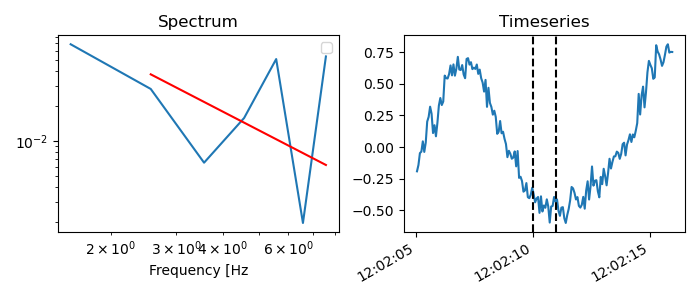

In [104]:
# Spectral segment start
t0s = t0 + pd.Timedelta(minutes=2, seconds=10)
dt = 1 # Spectral segment length, sec
seg = dsv.uU.sel(time=slice(t0s, t0s+pd.Timedelta(seconds=dt)))

# Spectrum estimation
fs = 16 # Sampling freq
# FFT of segment
fft_win = np.fft.fft(seg.values - np.mean(seg.values))
# Frequencies
n_freqs = int(np.floor(len(fft_win) / 2 )) # No. of frequency bands
# Calculate Nyquist frequency and bandwidth (freq. resolution)
nyquist = 0.5 * fs # Max spectral frequency
bandwidth = nyquist / n_freqs
# Find middle of each frequency band, only works when
# merging odd number of bands
f = 1/len(seg) + bandwidth/2 + bandwidth*np.arange(n_freqs)
ps_win = 2 * np.real(fft_win[:len(seg)//2] * np.conj(fft_win[:len(seg)//2]))

# Fit inertial subrange
def fun(x, c):
    return c * x ** (-5/3)

popt, pcov = optimize.curve_fit(fun, f[2:], ps_win[2:])
residuals = ps_win[2:]- fun(f[2:], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ps_win[2:]-np.mean(ps_win[2:]))**2)
r_squared = 1 - (ss_res / ss_tot)
print('r_sq: {:.2f}'.format(r_squared))

# Plot
fig, axes = plt.subplots(figsize=(7,3), ncols=2)
# Plot spectrum
axes[0].loglog(f[1:], ps_win[1:])
# Plot -5/3 tail
# axes[0].loglog(f[2:], f[2:]**(-5/3)*10, color='k', linestyle='--', label=r'$f^{-5/3}$')
# Plot fit
axes[0].loglog(f[2:], fun(f[2:], popt[0]), 'r-')
axes[0].set_xlabel('Frequency [Hz')
axes[0].set_title('Spectrum')
axes[0].legend()
# Plot segment time series
dts = 5 # +/- dt for plot segment
pseg = dsv.uE.sel(time=slice(t0s-pd.Timedelta(seconds=dts), 
                             t0s+pd.Timedelta(seconds=dt)+pd.Timedelta(seconds=dts)))
pseg.plot(ax=axes[1])
# Mark segment period
axes[1].axvline(t0s, color='k', linestyle='--')
axes[1].axvline(t0s+pd.Timedelta(seconds=dt), color='k', linestyle='--')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
axes[1].set_title('Timeseries')
plt.tight_layout()
plt.show()

In [50]:
def fun(x, c):
    return c * x ** (-5/3)

popt, pcov = optimize.curve_fit(fun, f[1:], ps_win[1:])
residuals = ps_win[1:]- fun(f[1:], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ps_win[1:]-np.mean(ps_win[1:]))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

-0.21961480699484004